## Project No1 - The Mind

Refer to the `README.md` for further information about how to play the game and the objectives for this first project. 

When writing code, we recommend you to be as modular as possible. For example, if you are running multiple experiments for different choices of parameters, it may be convenient to write a function that does one experiment and then make multiple calls to the same function. Follow the _do not repeat yourself_ rule when writing code! 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import beta
from scipy.stats import expon

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Let's start by creating a function that generates one sample of the game. Feel free to change this code as you find it suitable, for example by changing how the sampling is created or if you want to sample cards with replacement (this could be useful for the last questions).

In [2]:
def sample_cards(N, n, k):
    """
    Generates a simulated sample of how the cards are shuffled among players. 
    
    Arguments: 
        - N : Total number of cards
        - n : Number of players
        - k : Number of cards per player
        
    Returns: 
        - 2D numpy array where each row represent each player and each column their card in ascending order. 
    """
    
    assert n * k <= N, "There are not enough cards for all the players!"
    
    _cards = np.random.choice(a=np.arange(1, N+1), size=n*k, replace=False)
    _cards = _cards.reshape(n,k)
    _cards.sort(axis=1)
    return _cards

def sample_cards_stack(t, N, n, k):
    """
    Generates a simulated sample of how the cards are shuffled among players for each game. 
    
    Arguments: 
        - t : Number of games
        - N : Total number of cards
        - n : Number of players
        - k : Number of cards per player
        
    Returns: 
        - 3D numpy array where each row represent each player, each column each card and each depth each game.
    """
    
    cards_seq = [sample_cards(N, n, k) for _ in range(t)]
    cards_stack = np.stack(cards_seq)
    return cards_stack


def gap_all(cards_stack):
    """
    Sort the cards in ascending order for each game and compute the gap between each card.

    Arguments:
        - cards_stack : 3D numpy array where each row represent each player, each column each card and each depth each game.
    
    Returns:
        - 2D numpy array where each row represent each game and each column the gap between each card.
    """

    t, n, k = cards_stack.shape
    cards_matrix = cards_stack.reshape(t, n*k)
    cards_matrix = np.sort(cards_matrix, axis=1)
    cards_gap = np.diff(cards_matrix, axis=1)
    return cards_gap

def gap_diff(cards_stack):
    """
    Sort the cards in ascending order for each game and compute the gap between each card, only if the cards belong to different players.
    
    Arguments:
        - cards_stack : 3D numpy array where each row represent each player, each column each card and each depth each game.
    
    Returns:
        - 2D numpy array where each row represent each game and each column the gap between each card.
    """
    
    t, n, k = cards_stack.shape
    cards_matrix = cards_stack.reshape(t, n*k)
    player_idx = np.tile(np.arange(n),(k,1)).transpose().reshape(n*k)
    player_idx = np.tile(player_idx, (t,1))
    cards_idx = np.argsort(cards_matrix, axis=1)
    cards_matrix = np.take_along_axis(cards_matrix, cards_idx, axis=1)
    player_idx = np.take_along_axis(player_idx, cards_idx, axis=1)
    player_dif = np.diff(player_idx, axis=1)
    cards_gap = np.diff(cards_matrix, axis=1)
    cards_gap[player_dif==0] = 0
    return cards_gap

def gap_exp(t, N, n, k):
    """
    Get the statistics of the gap between each card for each game.
    
    Arguments:
        - t : Number of games
        - N : Total number of cards
        - n : Number of players
        - k : Number of cards per player

    Returns:
        - mean_gap : Mean gap between each card for each game
        - mean_gap_diff : Mean gap between each card for each game, only if the cards belong to different players
    """
    
    cards_stack = sample_cards_stack(t, N, n, k)
    cards_gap = gap_all(cards_stack)
    cards_gap_diff = gap_diff(cards_stack)
    mean_gap = cards_gap.max(axis=1).mean()
    mean_gap_diff = cards_gap_diff.max(axis=1).mean()
    return mean_gap, mean_gap_diff

def gap_plot_exp(t, N, n, k):
    """
    Plot the distribution of the gap between each card for each game.
    
    Arguments:
        - t : Number of games
        - N : Total number of cards
        - n : Number of players
        - k : Number of cards per player
    """
    
    cards_stack = sample_cards_stack(t, N, n, k)
    cards_gap = gap_all(cards_stack)
    cards_gap_diff = gap_diff(cards_stack)
    _, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].hist(cards_gap.max(axis=1).ravel(), bins=np.arange(0, N+1))
    mean_gap = cards_gap.max(axis=1).mean()
    ax[0].axvline(mean_gap, color='r', linestyle='--', label=f'Mean gap: {mean_gap:.2f}')
    ax[0].set_title('Max gap')
    ax[1].hist(cards_gap_diff.max(axis=1).ravel(), bins=np.arange(0, N+1))
    mean_gap_diff = cards_gap_diff.max(axis=1).mean()
    ax[1].axvline(mean_gap_diff, color='r', linestyle='--', label=f'Mean gap: {mean_gap_diff:.2f}')
    ax[1].set_title('Max gap (different players)')
    ax[0].legend()
    ax[1].legend()
    plt.show()
    print(f'Mean gap difference: {mean_gap - mean_gap_diff:.2f}')

Now we can just generate how cards are distributed among players by simply making a call to this function with the desired parameters. 

In [3]:
cards = sample_cards(100, 6, 3)
cards

array([[71, 76, 83],
       [56, 88, 92],
       [15, 30, 79],
       [18, 43, 63],
       [48, 96, 99],
       [14, 49, 59]])

and access the cards of each player with 

In [4]:
player0 = cards[0,:]
player1 = cards[1,:]
player0, player1

(array([71, 76, 83]), array([56, 88, 92]))

The lowest card in the game is

In [5]:
np.min(cards)

14

In [6]:
np.arange(1, 5)

array([1, 2, 3, 4])

### 1. What is the distribution of the lowest number? 

Repeat the sampling of the cards multiple times for the same choice of `N`, `n` and `k` and plot the distribution of the lowest number in the sample. Use an [histogram](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) to plot the distribution and set the bins to be the available integer number cards. 

In [7]:
t = 400000
cards_stack = sample_cards_stack(t, 100, 6, 3)
cards_stack.shape

(400000, 6, 3)

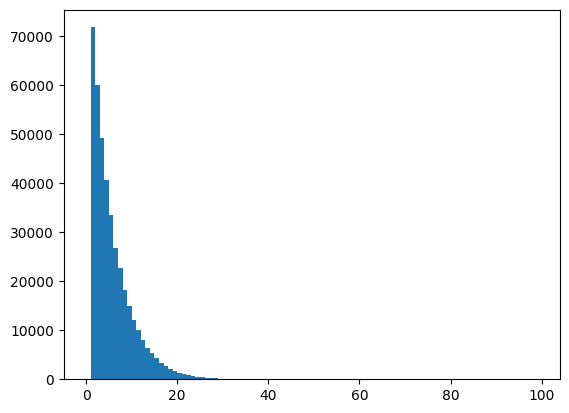

In [8]:
cards_min = cards_stack.min(axis=1).min(axis=1)
plt.hist(cards_min, bins=np.arange(0,100,1))
plt.show()

### 2. What is the distribution of the largest gap?

For each simulation, found the largest distance between consecutive numbers in the game. To make this easy, let us first consider the largest gap among the pool of **all** the cards among players (if the largest gap is happening in the hand of one single player, that is ok). This will make the analysis more simple. 

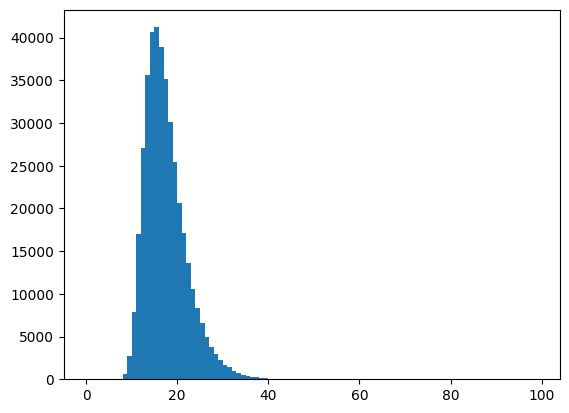

In [9]:
cards_gap = gap_all(cards_stack)
plt.hist(cards_gap.max(axis=1).ravel(), bins=np.arange(0,100,1))
plt.show()

In [10]:
print(cards_gap.max(axis=1)[:25])

[16 15 17 17 15 12 19 16 19 11 19 12 15 12 20 14 27 20 15 14 16 19 19 23
 13]


Repeat the experiment but know compute the largest gap between cards of different players. This is the gap that actually matters for the purposes of the game: what is the maximum number of numbers that a player will have to wait before playing the next card?

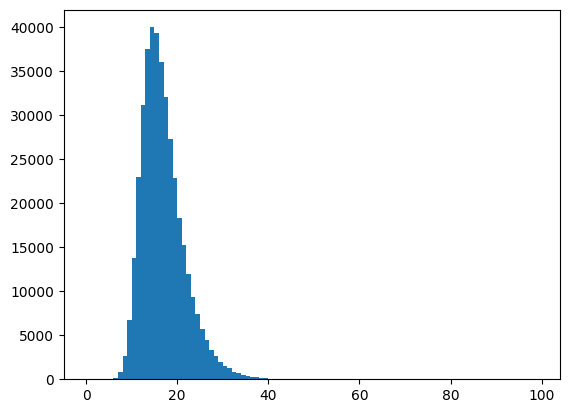

In [11]:
cards_gap_diff = gap_diff(cards_stack)
plt.hist(cards_gap_diff.max(axis=1).ravel(), bins=np.arange(0,100,1))
plt.show()

How does these compare? Run simulations for different choices of the number of cards and players and see when the difference between these two is larger. 

Compute the mean of the two distributions. When this difference is larger? How does this depends of the total number of players `n`?

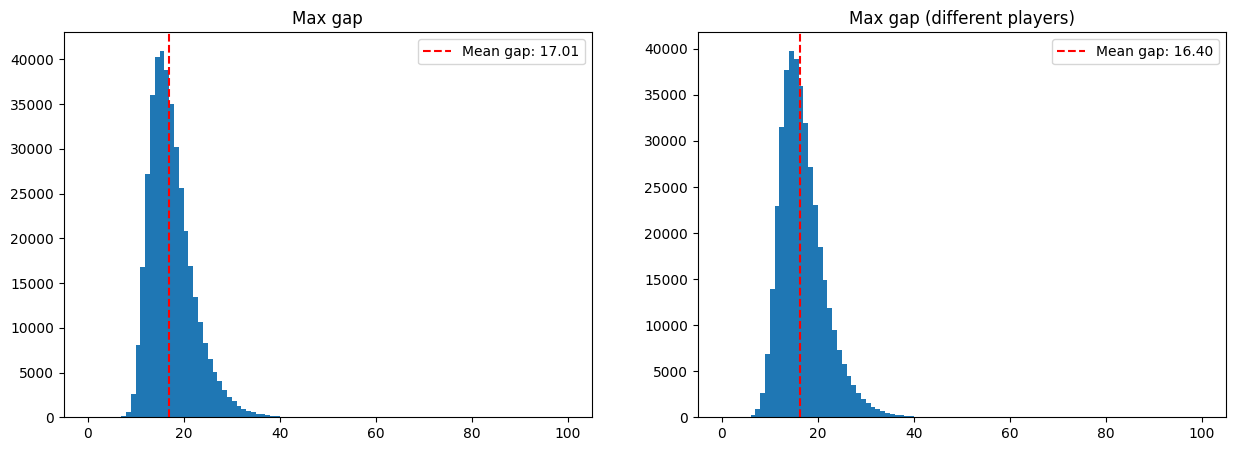

Mean gap difference: 0.60


In [12]:
# To Do cell
gap_plot_exp(400000, 100, 6, 3)

In [13]:
stats = []
for n in range(2, 11):
    for k in range(2, 11):
        mean_gap, mean_gap_diff = gap_exp(4000, 100, n, k)
        stats.append([n, k, mean_gap, mean_gap_diff])
df = pd.DataFrame(stats, columns=['n', 'k', 'mean_gap', 'mean_gap_diff'])
df['gap_delta'] = df['mean_gap'] - df['mean_gap_diff']
df

,n,k,mean_gap,mean_gap_diff,gap_delta
0,2,2,36.42750,29.01375,7.41375
1,2,3,32.35100,25.13375,7.21725
2,2,4,28.40825,22.30000,6.10825
3,2,5,25.16875,19.73550,5.43325
4,2,6,22.40500,17.93275,4.47225
...,...,...,...,...,...
76,10,6,5.51350,5.42400,0.08950
77,10,7,4.48350,4.40800,0.07550
78,10,8,3.56500,3.50525,0.05975
79,10,9,2.71275,2.67200,0.04075


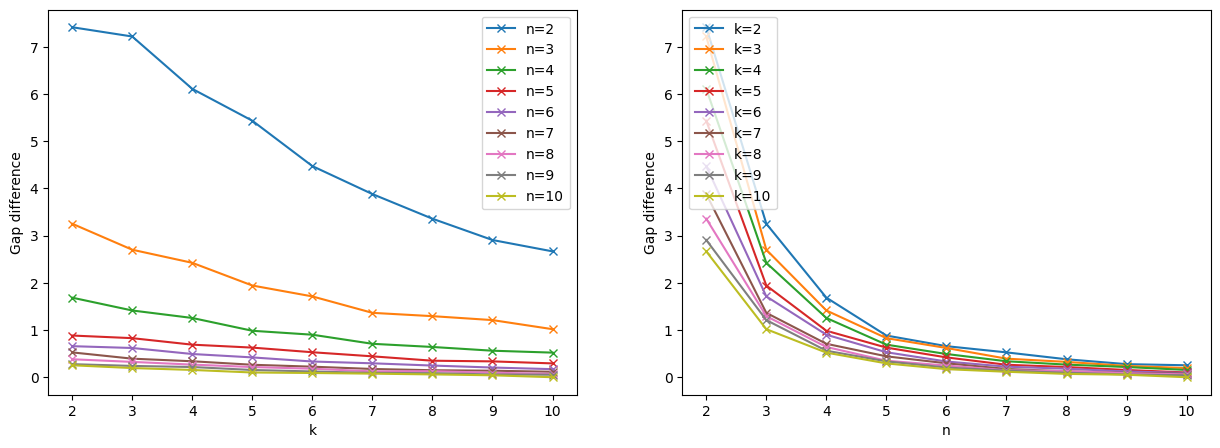

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
for n in range(2, 11):
    ax[0].plot(df[df['n']==n]['k'], df[df['n']==n]['gap_delta'], label=f'n={n}', marker='x')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Gap difference')
    ax[0].legend(loc='upper right')
for k in range(2, 11):
    ax[1].plot(df[df['k']==k]['n'], df[df['k']==k]['gap_delta'], label=f'k={k}', marker='x')
    ax[1].set_xlabel('n')
    ax[1].set_ylabel('Gap difference')
    ax[1].legend(loc='upper left')
plt.show()

### 3. Deriving distributions

For this section, we are going to use the random sampling generating process from _The Mind_ to investigate and find some familiar distributions.

### 3.1. Binomial Distribution 

Can you think about any way of deriving the binomial distribution? Based on the output of one single game (function `sample_game()`), try to derive something that has Binomial distribution for certain parameter $p$. Run multiple simulations to see this and compare the obtained empirical distribution with the distribution of the binomial distribution (check `numpy.random.binomial` and `scipy.stats.binom`). 

### A 3.1 Binomial Distribution:
Suppose a game with only one player drawing $k$ cards from $N$ cards. Given probability $p$ of success, and $n$ trials testing if all cards drawn are no greater than $M=N\cdot p$, the success number $X$ (approximately) follows a binomial distribution $\mathrm{Binom}(k,p)$. This is only true when $k$ is small compared to $N$.

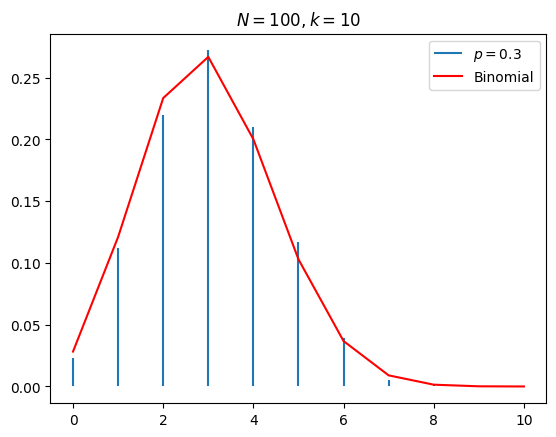

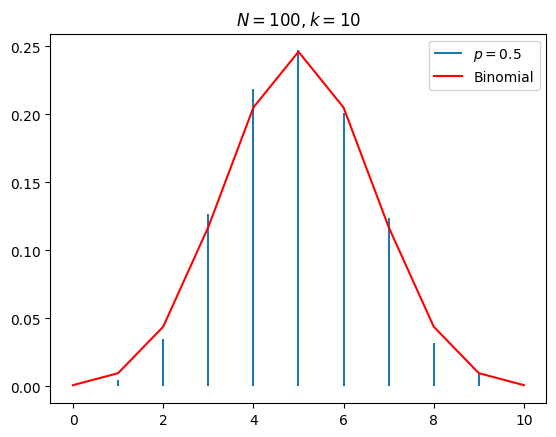

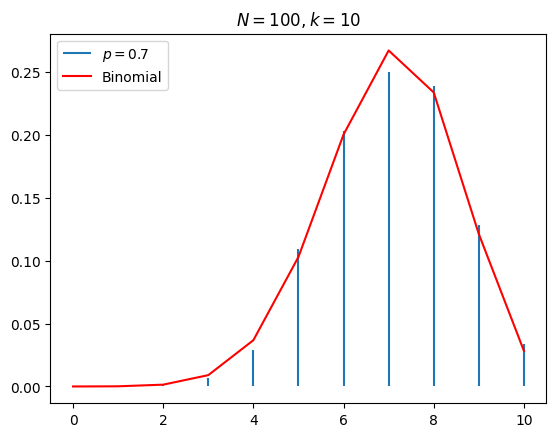

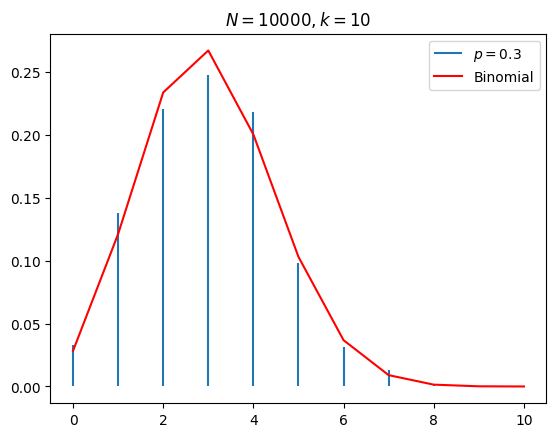

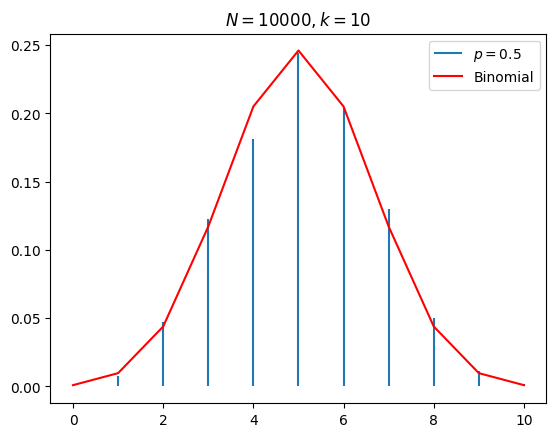

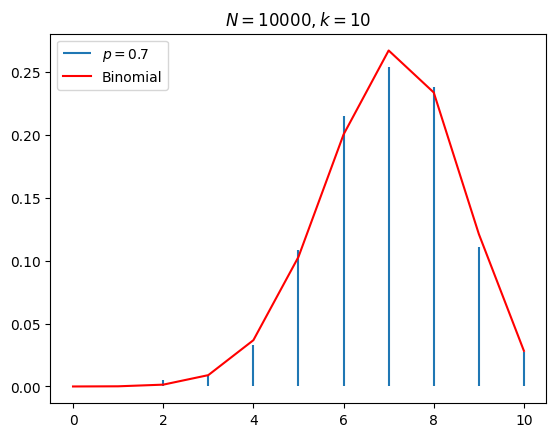

In [15]:
t = 1000
k = 10
for N in [100, 10000]:#, 100000]:
    for p in [0.3,0.5,0.7]:
        M = int(p*N)
        cards_stack = sample_cards_stack(t, N, 1, k)
        player_one = cards_stack[:,0,:]
        X = np.sum(player_one <= M, axis=1)
        unique, counts = np.unique(X, return_counts=True)
        counts = counts / t
        rv = binom(k, M/N)
        plt.vlines(unique, 0, counts, label=f'$p={M/N:.1f}$')
        x = np.arange(0, k+1)
        plt.plot(x, rv.pmf(x), label='Binomial', color='r')
        plt.legend()
        plt.title(f'$N={N}, k={k}$')
        plt.show()

### 3.2. Beta Distribution

The [order statistics](https://en.wikipedia.org/wiki/Order_statistic) of the uniform distribution are such that follow a Beta distribution. If well here we are not exactly sampling real numbers in $[0,1]$ following the uniform distribution, you can imagine that sampling one single number without repetition from $\{ 1, 2, 3, \ldots, N \}$ is not very different...

Compare the distribution of the lowest number in the sample (Part 1) with a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with adequate choices of parameters. In order to do this, notice that the $k$-th order statistics of a sample of $n$ uniformly distributed points in $[0,1]$ is $\text{Beta}(k, n+1-k)$ (These $n$ and $k$ are not the same as before, you need to pick the right values of these).

In [16]:
# To Do cell
t = 400000
n = 6
k = 3
N = 100
cards_stack = sample_cards_stack(t, N, n, k)
cards_min = cards_stack.min(axis=1).min(axis=1)
unique, counts = np.unique(cards_min, return_counts=True)
counts = counts / t


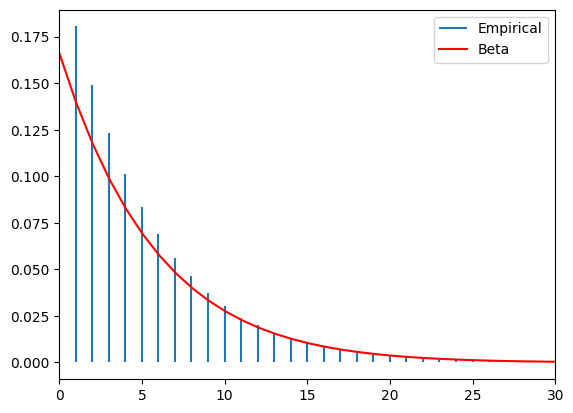

In [17]:
rv = beta(1,n*k)
plt.vlines(unique, 0, counts, label=f'Empirical')
x = np.linspace(0, 1, 100)
plt.plot(N*x, rv.pdf(x)/np.sum(rv.pdf(x)), label='Beta', color='r')
plt.xlim(0,30)
plt.legend()
plt.show()


### 3.3. Exponential Distribution

If we call $U_1$ the minimum number in the sample (Part 1), then make an histogram with the distribution of the transformed random variable given by 
$$
X = - \ln \left( 1 - \frac{U_1}{N} \right)
$$
and compare this with the distribution of an exponential random variable with parameter $nk$, the total number of cards in the game. 

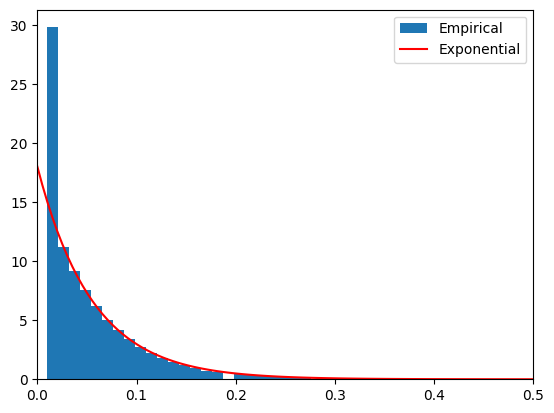

In [18]:
cards_min_log = -np.log(1-cards_min/N)
exp_dist = expon(scale=1/(n*k))
plt.hist(cards_min_log, bins=60, density=True, label='Empirical')
x = np.linspace(0, 0.5, 100)
plt.plot(x, exp_dist.pdf(x), color='r', label='Exponential')
plt.legend()
plt.xlim(0,0.5)
plt.show()

### 4. What happens when $n * k << N$?

Some of the distribution we saw in previous sections are just approximate. Study what happens when we increase the number of cards. Try to understand how the cases of sampling with and without reposition compare as $n * k << N$. What do you expect to see in these cases? When the difference between the two sampling strategies will lead to similar or different results. 

### A 4. Approximation
We can see from the plots below that as $n\cdot k \ll N$, the empirical distribution approaches theoretical distributions from `scipy.stats`. The sampling strategy with replacement will directly yield given theoretical distributions, and increasing $N$ makes the sampling strategy without replacement more and more similar to the sampling strategy with replacement.

In [19]:
t = 500000
n = 6
k = 3
N = 100000
def min_cards(N, n, k, t):
    cards_min = np.zeros(t)
    for i in range(t):
        cards = np.random.choice(a=np.arange(1, N+1), size=n*k, replace=True)
        cards_min[i] = cards.min(axis=0)
    return cards_min
cards_min = min_cards(N, n, k, t)
unique, counts = np.unique(cards_min, return_counts=True)

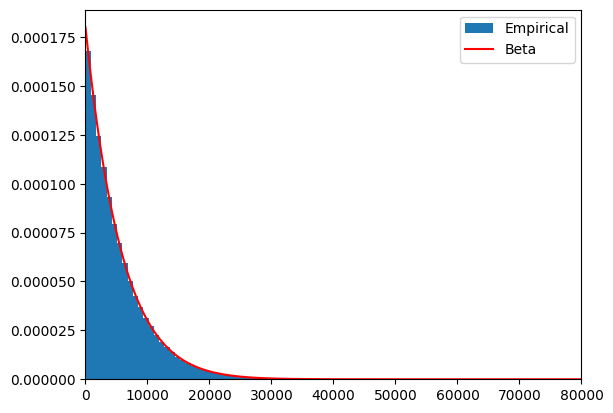

In [20]:
rv = beta(1,n*k)
#plt.vlines(unique, 0, counts, label=f'Empirical')
plt.hist(cards_min, bins=60, density=True, label='Empirical')
x = np.linspace(0, 1, 100000)
plt.plot(N*x, rv.pdf(x)/np.sum(rv.pdf(x)), label='Beta', color='r')
plt.xlim(0,80000)
plt.legend()
plt.show()

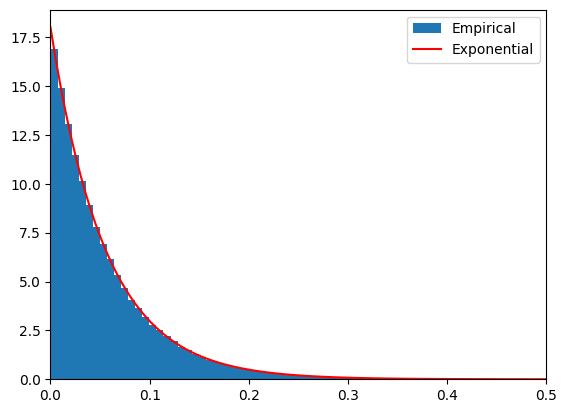

In [21]:
cards_min_log = -np.log(1-cards_min/N)
exp_dist = expon(scale=1/(n*k))
plt.hist(cards_min_log, bins=100, density=True, label='Empirical')
x = np.linspace(0, 0.5, 100)
plt.plot(x, exp_dist.pdf(x), color='r', label='Exponential')
plt.legend()
plt.xlim(0,0.5)
plt.show()

### Contribution statement

Please include a list of the students you work with along this project (including yourself). Include both names and GitHub usernames of the people you collaborated with. Maximum of three persons per group. 
- Member No1: Leon (Wuji) Han, GitHub: LeonWujiHan 
- Member No2: 
- Member No3: